In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### This shows us a summary of numerical attributes

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

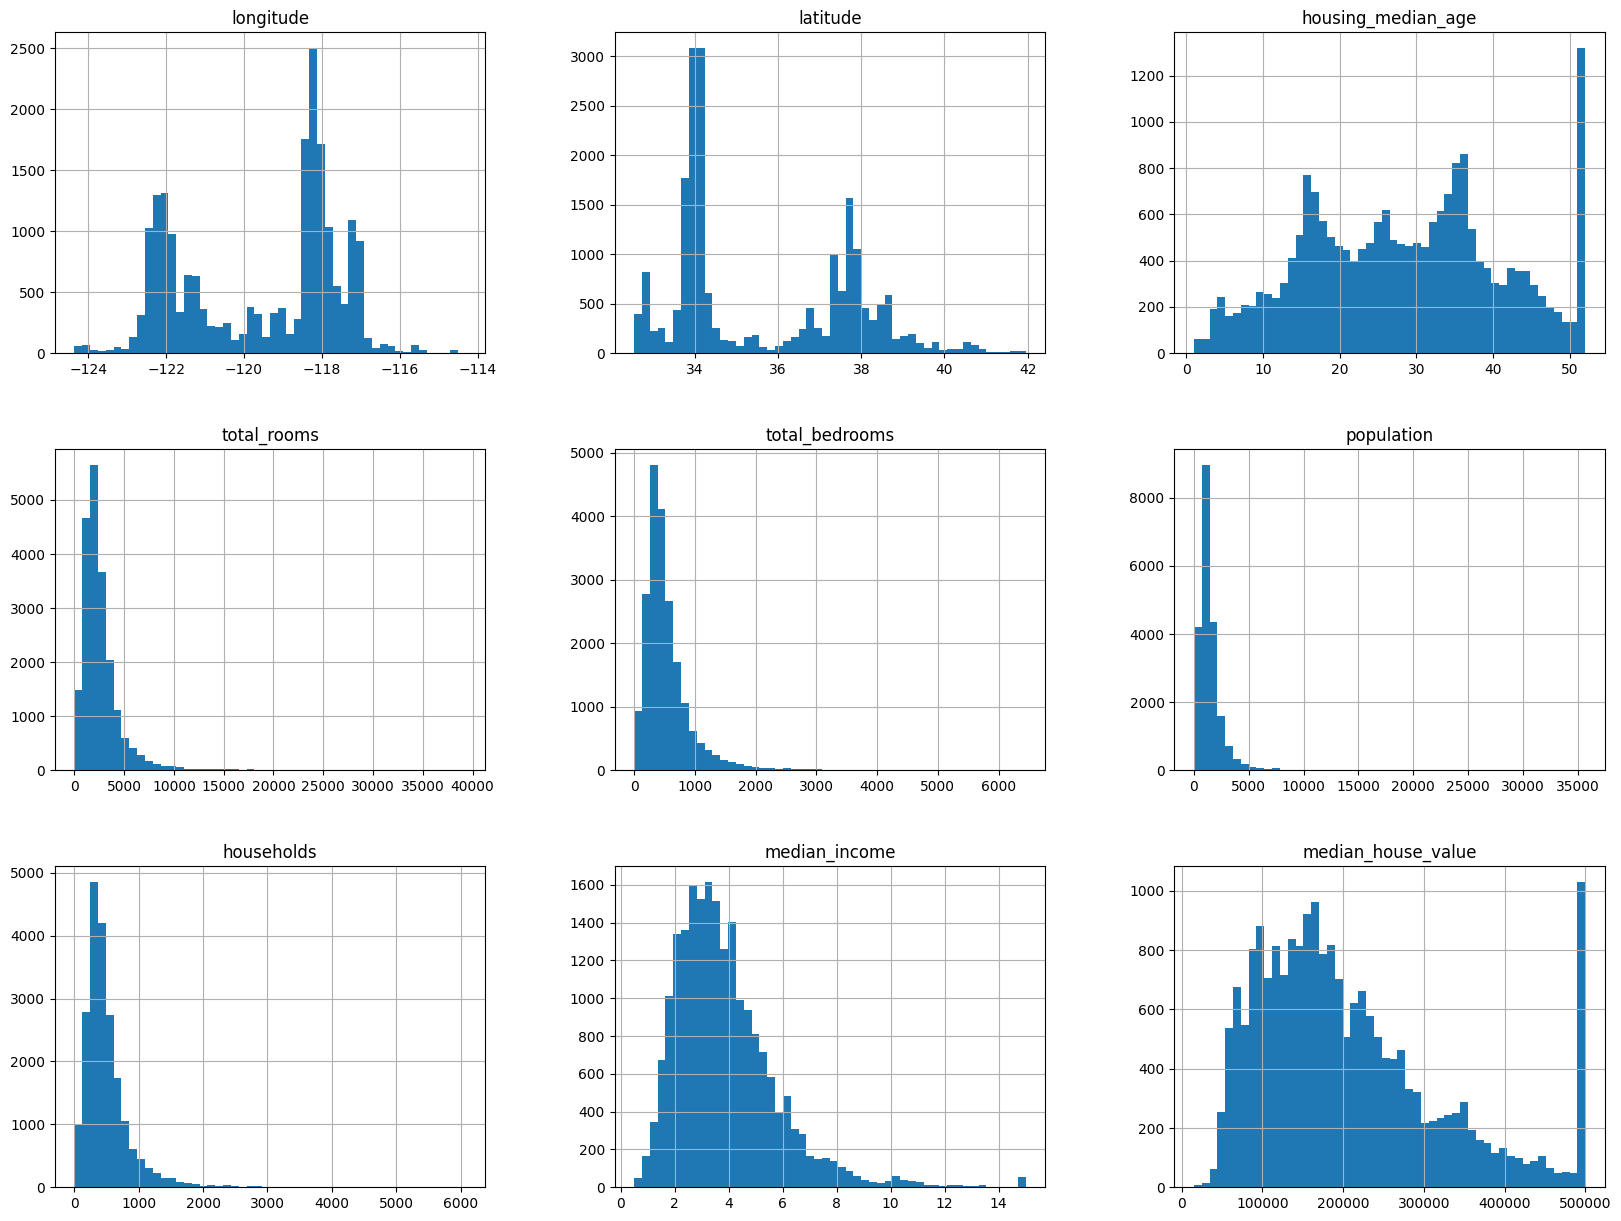

In [6]:
data.hist(bins=50, figsize=(20,15))

Looking at the data it can be deduced that :
1. the median age is capped
2. the median house income is also capped from (0.5 - 15) i.e 3 actually means 30,000$
3. the histograms are skewed (many are shifed to the right to the median than left)

## Now its time to separate a test data and train data 

In [7]:
## Function to shuffle the data and split the data

def shuffle_and_split_data(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data)) ## Shuffling indices
    test_set_size = int(len(data)*test_ratio) ## Calculating test set size
    test_indices = shuffled_indices[:test_set_size] ## Splitting the data
    train_indices = shuffled_indices[test_set_size:]   ## Splitting the data
    return data.iloc[train_indices],data.iloc[test_indices] ## Returning the data (train and test)

train_set,test_set = shuffle_and_split_data(data,0.2) ## Calling the function

In [8]:
len(test_set)

4128

In [9]:
len(train_set)

16512

### The Problem:
If you randomly split your data (for example, by shuffling it), the test set will change every time you run your program. This means that over time, your model might see data from the test set during training, which can give misleading results.

### Common (but imperfect) Solutions:
Saving the test set: Keep the same test set by saving it after the first split.
Setting a random seed: Fix the random number generator so that the same shuffle occurs every time.
Both of these methods work only until your data changes (new data is added or some rows are deleted).

### A Better, Stable Approach:
- Use a unique identifier for each data point (like an ID) and decide which set it belongs to by computing a hash (a number derived from the ID).
- The idea is to put an instance in the test set if the hash of its ID is below a certain threshold (like 20% of the maximum possible hash value).
-This method ensures that each instance is always assigned to the same set, even if you update your data.
For example, if you add new data, only those new points that meet the criteria (hash is low enough) will go to the test set. Old instances remain in their original sets.

### What to Do If You Don’t Have a Unique ID:
- You can use the row index (the default numbering of rows) as the ID, but only if you add new data at the end and never remove any rows.
- Alternatively, you can create an ID from stable features (like combining longitude and latitude for a house), since these values don’t change over time.

In [10]:
from zlib import crc32 ## id = "unique_id"

def is_id_in_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data,test_ratio,id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]

In [11]:
housing_with_id = data.reset_index() ## Adding index column
train_set,test_set = split_data_with_id_hash(housing_with_id,0.2,"index") ## Calling the function

In [12]:
housing_with_id["id"] = data["longitude"]*1000 + data["latitude"] ## Creating a unique id
train_set,test_set = split_data_with_id_hash(housing_with_id,0.2,"index") ## Calling the function

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways, the simplest function is train_test_split(), which does prettymuch same thing as the shuffle_and_split func we defined earlier, with a couple of additional features. First, there is a random_state parameter that allows you to set the random generator seed. Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):

In [13]:
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(data,test_size=0.2,random_state=42) ## Using sklearn function


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

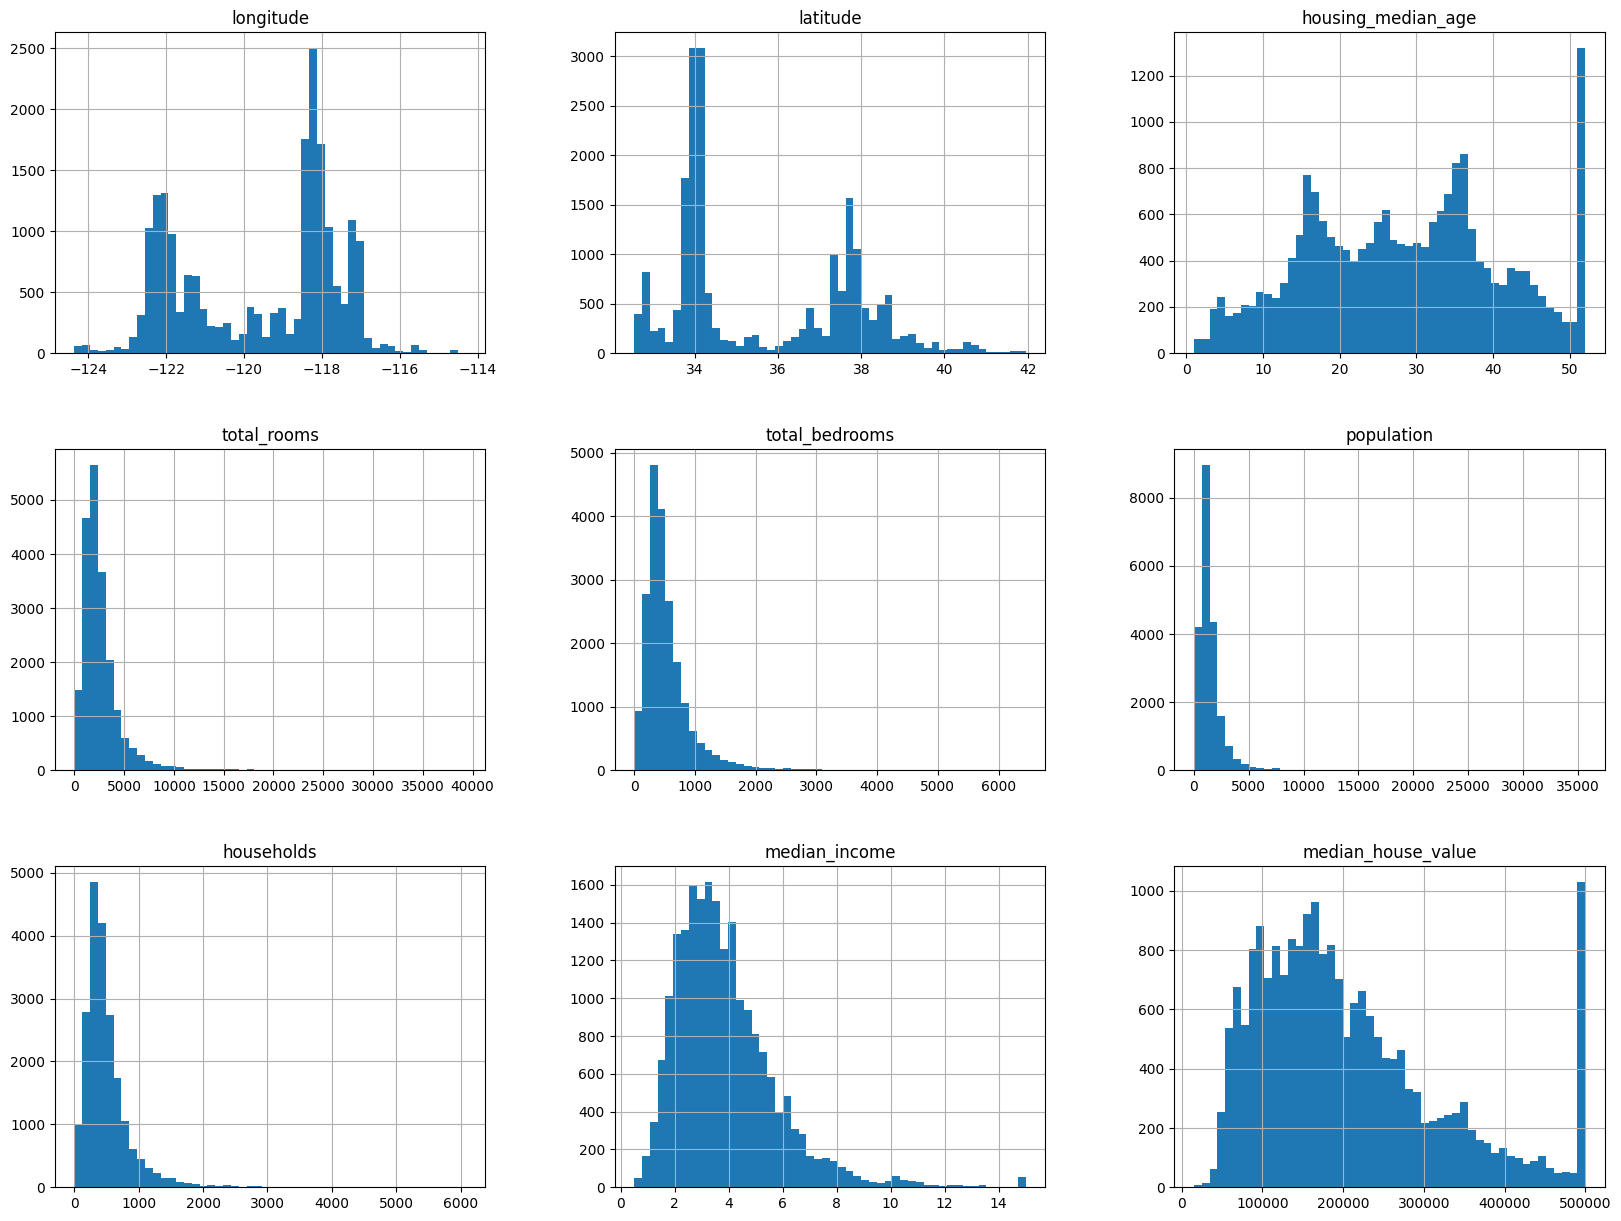

In [14]:
data.hist(bins=50, figsize=(20,15))

Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased.

In [15]:
data["income_category"] = pd.cut(data["median_income"],bins=[0,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])


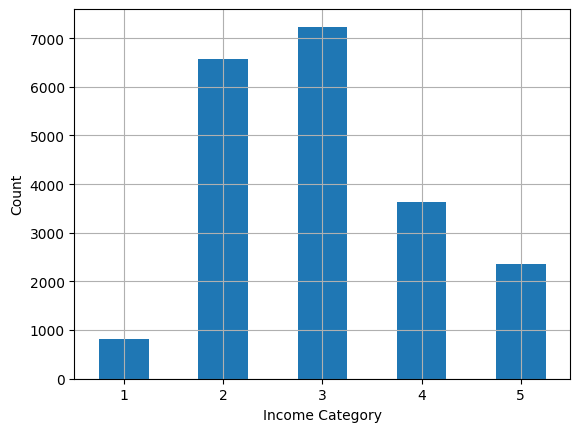

In [16]:
data["income_category"].value_counts().sort_index().plot.bar(rot = 0, grid = True)   ## id = "Income-Histogram"
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()

Now we are ready to do stratified sampling based on income category

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit ## id = "StratSplit"

splitter = StratifiedShuffleSplit(n_splits=10, test_size = 0.2,random_state=42) ## Creating a stratified splitter
strat_splits=[] ## List to store the splits
for train_index , test_index in splitter.split(data, data["income_category"]):
    strat_train_set_n = data.iloc[train_index] ## Getting the training data
    strat_test_set_n = data.iloc[test_index] ## Getting the test data
    strat_splits.append([strat_train_set_n,strat_test_set_n]) ## Appending the data to the list

In [18]:
## Shorter way to stratify the data

strat_train_set, strat_test_set = train_test_split(data ,test_size = 0.2, stratify=data["income_category"],random_state=42) ## Using sklearn function

In [19]:
strat_test_set["income_category"].value_counts()/len(strat_test_set) ## Checking the ratio of the test set

income_category
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
strat_train_set["income_category"].value_counts()/len(strat_train_set) ## Checking the ratio of the train set

income_category
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [21]:
for set in (strat_train_set,strat_test_set):
    set.drop("income_category",axis=1,inplace=True) ## Dropping the income category

First, make sure we have put the test set aside and we are only exploring the training set

Let’s create a copy so that we can play with it without harming the training set:

In [22]:
dataset = strat_train_set.copy() ## Creating a copy of the training data

VISUALISING GEOGRAPHICAL DATA

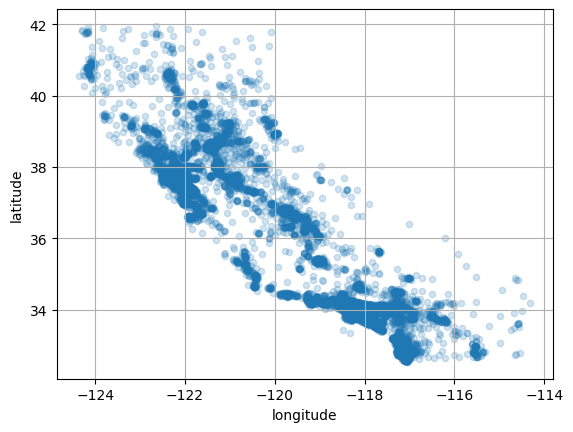

In [23]:
dataset.plot(kind="scatter",x = "longitude",y = "latitude",grid = True,alpha = 0.2)
plt.show()

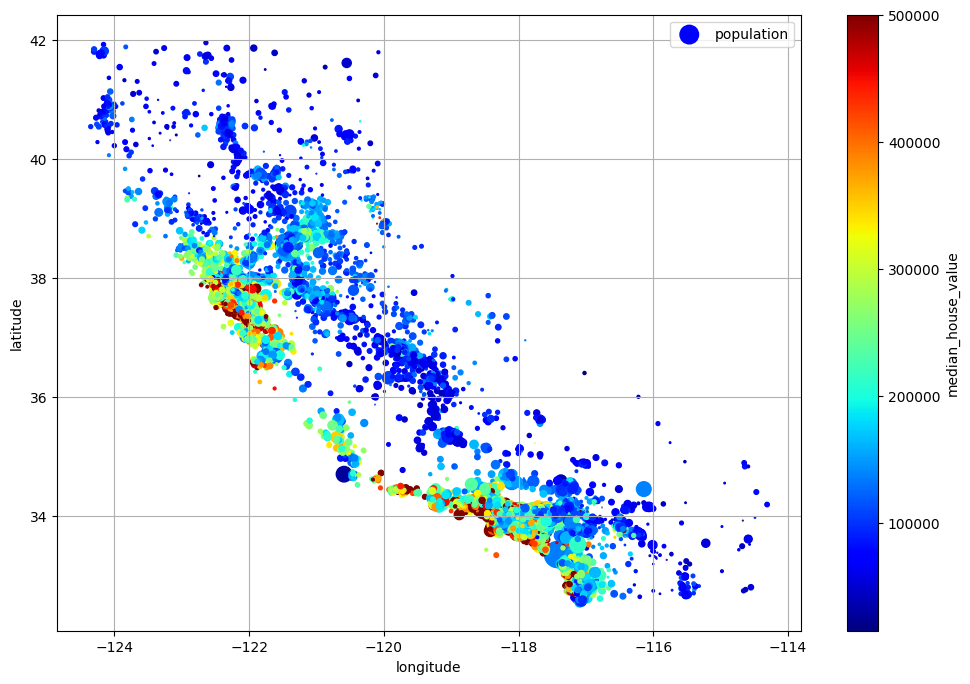

In [24]:
dataset.plot(kind = "scatter",x = "longitude",y = "latitude",grid=True, s = dataset["population"]/100,label = "population",c = "median_house_value",cmap = "jet",colorbar = True,legend = True,sharex = True,figsize = (12,8))
plt.show()

In [25]:
corr_matrix = dataset.corr(numeric_only=True) 
corr_matrix["median_house_value"].sort_values(ascending=False) 

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

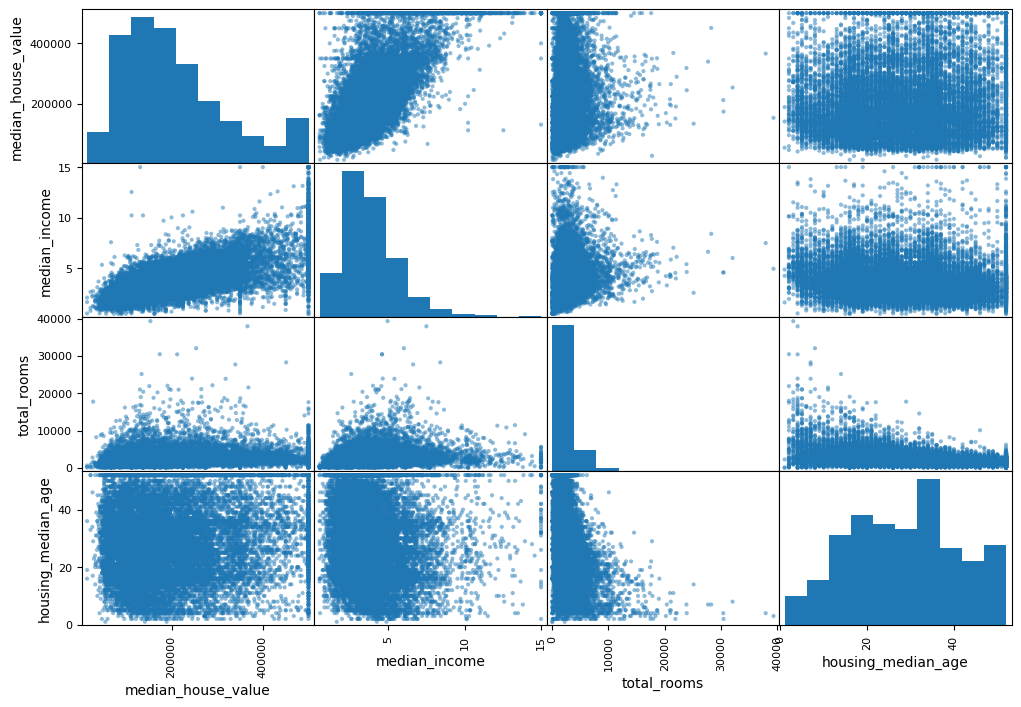

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]

scatter_matrix(dataset[attributes],figsize=(12,8))

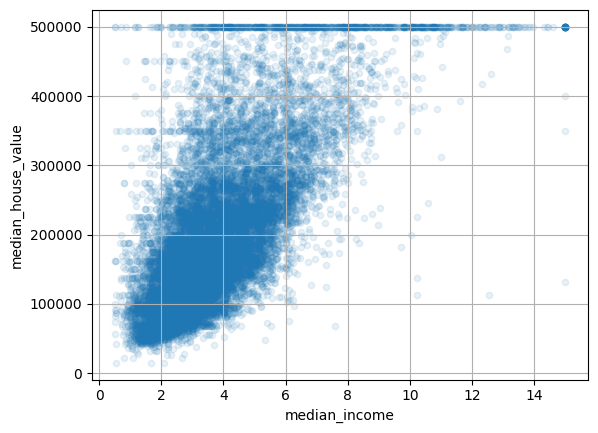

In [27]:
dataset.plot(kind= "scatter",x = "median_income",y = "median_house_value",alpha = 0.1,grid = True)
plt.show()

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. But this plot reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that. We may want to try removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

In [28]:
dataset["rooms_per_house"] = dataset["total_rooms"]/dataset["households"]
dataset["bedrooms_per_room"] = dataset["total_bedrooms"]/dataset["total_rooms"]
dataset["population_per_house"] = dataset["population"]/dataset["households"]


In [29]:
corr_matrix = dataset.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687151
rooms_per_house         0.146255
total_rooms             0.135140
housing_median_age      0.114146
households              0.064590
total_bedrooms          0.047781
population_per_house   -0.021991
population             -0.026882
longitude              -0.047466
latitude               -0.142673
bedrooms_per_room      -0.259952
Name: median_house_value, dtype: float64

In [30]:
data = strat_train_set.drop("median_house_value",axis=1)
data_labels = strat_train_set["median_house_value"].copy()

## Clean the Data

In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
data_num = data.select_dtypes(include=[np.number])
imputer.fit(data_num)

SimpleImputer(strategy='median')

In [32]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [33]:
data_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [34]:
X = imputer.transform(data_num)

In [35]:
data_tr = pd.DataFrame(X,columns = data_num.columns,index = data_num.index)

## Handling text and categorial attributes

In [36]:
housing_category = data[["ocean_proximity"]]
housing_category.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [37]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_category_encoded = ordinal_encoder.fit_transform(housing_category)
housing_category_encoded[1:8]

array([[4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [38]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder  = OneHotEncoder()
housing_category_1hot = cat_encoder.fit_transform(housing_category)
housing_category_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [40]:
df_test = pd.get_dummies(data["ocean_proximity"],dtype=int)
df_test

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,0,1,0,0,0
15502,0,0,0,0,1
2908,0,1,0,0,0
14053,0,0,0,0,1
20496,1,0,0,0,0
...,...,...,...,...,...
15174,1,0,0,0,0
12661,0,1,0,0,0
19263,1,0,0,0,0
19140,1,0,0,0,0


## OneHotEncoder is better than pd.get_dummies because it remembers which categories it was trained on. This is very important because once your model is in production, it should be fed exactly the same features as during training, no more, no less.

In [46]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [43]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [50]:
data = dataset.copy()
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_per_room,population_per_house
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,6.658342,0.184696,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,5.571932,0.179977,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,4.110465,0.234795,2.662791
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,6.297405,0.183835,2.411178


In [ ]:
from sklearn.preprocessing import MinMaxScaler 

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(data_num)

### Min-max scaling (many people call this normalization) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets us change the range if, for some reason, you don’t want 0–1.

In [52]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(data_num)

### Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected

In [ ]:
from sklearn.linear_model import LinearRegression   ## id = "regression1"

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(data_labels.to_frame())

model = LinearRegression()
model.fit(data[["median_income"]],scaled_labels)
some_new_data = data[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
